In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('https://github.com/doski-codes/bpnn-ngsim-congestion/blob/master/datasets/NGSIM_US101_congestion.csv?raw=true')

In [3]:
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
0,515,2330.0,1123.0,2005-06-15 08:07:55-07:00,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0.333333,0.116667,0
1,2127,6459.0,567.0,2005-06-15 08:00:24.800000-07:00,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0.333333,0.000000,0
2,1033,4827.0,592.0,2005-06-15 08:12:04.700000-07:00,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0.333333,0.200000,0
3,1890,9157.0,628.0,2005-06-15 08:34:32.700000-07:00,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,0.333333,0.566667,0
4,744,3392.0,996.0,2005-06-15 08:09:41.200000-07:00,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,0.333333,0.150000,0


In [4]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'Preceding', 'Following', 'Space_Headway',
       'Time_Headway', 'Hours', 'Minutes', 'Congestion'],
      dtype='object')

In [5]:
df.duplicated().sum()

0

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455846 entries, 0 to 455845
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Vehicle_ID     455846 non-null  int64  
 1   Frame_ID       455846 non-null  float64
 2   Total_Frames   455846 non-null  float64
 3   Global_Time    455846 non-null  object 
 4   Local_X        455846 non-null  float64
 5   Local_Y        455846 non-null  float64
 6   Global_X       455846 non-null  float64
 7   Global_Y       455846 non-null  float64
 8   v_length       455846 non-null  float64
 9   v_Width        455846 non-null  float64
 10  v_Class        455846 non-null  float64
 11  v_Vel          455846 non-null  float64
 12  v_Acc          455846 non-null  float64
 13  Lane_ID        455846 non-null  float64
 14  Preceding      455846 non-null  float64
 15  Following      455846 non-null  float64
 16  Space_Headway  455846 non-null  float64
 17  Time_Headway   455846 non-nul

# Exploratory Data Analysis

#### Handling Data Columns
Most of the columns contain data: 
- are not necessary for prediction  
- would create a bias in our prediction model
- would make it impossible to use the model in real time

#### Data Categories
Plotting graphs or counting categories in various columns to see the distribution of the data

#### Graphs
- Plotting graphs to see the behaviour of the data by time (Time Series).
- Correlation heat map to see the correlation between the variables

In [8]:
df.drop(['Local_X', 'Local_Y', 'Global_X', 'Global_Y', 'Vehicle_ID', 'Frame_ID', 'Total_Frames',
        'Preceding', 'Following', 'Space_Headway', 'Time_Headway', 'Hours', 'Minutes'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.head()

,Global_Time,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion
0,2005-06-15 08:07:55-07:00,13.0,6.9,2.0,23.31,2.05,3.0,0
1,2005-06-15 08:00:24.800000-07:00,13.5,6.9,2.0,37.52,11.20,2.0,0
2,2005-06-15 08:12:04.700000-07:00,13.5,4.4,2.0,41.99,0.10,1.0,0
3,2005-06-15 08:34:32.700000-07:00,24.0,8.5,3.0,45.12,-0.55,5.0,0
4,2005-06-15 08:09:41.200000-07:00,15.0,5.9,2.0,24.54,-0.04,3.0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455846 entries, 0 to 455845
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Global_Time  455846 non-null  object 
 1   v_length     455846 non-null  float64
 2   v_Width      455846 non-null  float64
 3   v_Class      455846 non-null  float64
 4   v_Vel        455846 non-null  float64
 5   v_Acc        455846 non-null  float64
 6   Lane_ID      455846 non-null  float64
 7   Congestion   455846 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 27.8+ MB


In [11]:
# Convert data types
df['Global_Time'] = pd.to_datetime(df['Global_Time']).dt.tz_convert('US/Pacific')

In [12]:
df.head()

,Global_Time,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion
0,2005-06-15 08:07:55-07:00,13.0,6.9,2.0,23.31,2.05,3.0,0
1,2005-06-15 08:00:24.800000-07:00,13.5,6.9,2.0,37.52,11.20,2.0,0
2,2005-06-15 08:12:04.700000-07:00,13.5,4.4,2.0,41.99,0.10,1.0,0
3,2005-06-15 08:34:32.700000-07:00,24.0,8.5,3.0,45.12,-0.55,5.0,0
4,2005-06-15 08:09:41.200000-07:00,15.0,5.9,2.0,24.54,-0.04,3.0,0


In [13]:
# Extract time features
df['Time_Hour'] = df['Global_Time'].dt.hour
df['Time_Minute'] = df['Global_Time'].dt.minute
df['Time_Second'] = df['Global_Time'].dt.second
df['Time'] = df['Global_Time'].dt.strftime('%H:%M:%S')

In [14]:
df.head()

,Global_Time,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion,Time_Hour,Time_Minute,Time_Second,Time
0,2005-06-15 08:07:55-07:00,13.0,6.9,2.0,23.31,2.05,3.0,0,8,7,55,08:07:55
1,2005-06-15 08:00:24.800000-07:00,13.5,6.9,2.0,37.52,11.20,2.0,0,8,0,24,08:00:24
2,2005-06-15 08:12:04.700000-07:00,13.5,4.4,2.0,41.99,0.10,1.0,0,8,12,4,08:12:04
3,2005-06-15 08:34:32.700000-07:00,24.0,8.5,3.0,45.12,-0.55,5.0,0,8,34,32,08:34:32
4,2005-06-15 08:09:41.200000-07:00,15.0,5.9,2.0,24.54,-0.04,3.0,0,8,9,41,08:09:41


In [15]:
df.describe()

,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion,Time_Hour,Time_Minute,Time_Second
count,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,0.018884,7.833319,24.158093,29.414658
std,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,0.136114,0.372691,16.528372,17.309386
min,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,7.000000,0.000000,0.000000
25%,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,0.000000,8.000000,11.000000,14.000000
50%,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,0.000000,8.000000,22.000000,29.000000
75%,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,0.000000,8.000000,32.000000,44.000000
max,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,1.000000,8.000000,59.000000,59.000000


In [16]:
# Check the most and least vehicle lengths in the data
df.v_length.value_counts().sort_values()

47.0       42
39.0       42
61.5       42
54.5       46
65.0       47
        ...  
16.0    37600
14.0    41390
15.5    47361
14.5    51479
15.0    52482
Name: v_length, Length: 97, dtype: int64

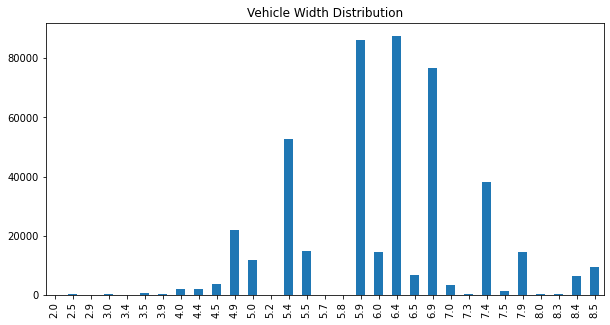

In [17]:
# Distribution of vehicle widths in the data
ax = df.v_Width.value_counts().sort_index().plot(kind='bar', figsize=(10,5), title='Vehicle Width Distribution')

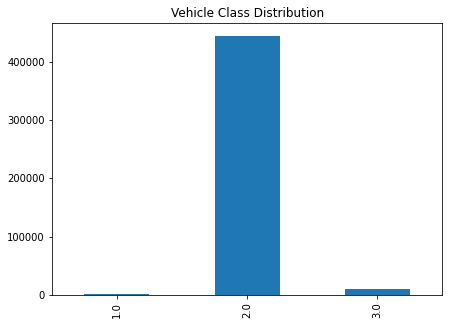

In [18]:
# Graph to show v_Class distribution
ax = df.v_Class.value_counts().sort_index().plot(kind='bar', figsize=(7,5), title='Vehicle Class Distribution')

In [19]:
# The number of vehicles that used each lane
df.Lane_ID.value_counts()

2.0    94821
1.0    93273
3.0    89603
4.0    88966
5.0    81591
6.0     5614
7.0     1409
8.0      569
Name: Lane_ID, dtype: int64

In [20]:
speed_columns = ['v_Vel', 'v_Acc']

<Figure size 432x288 with 0 Axes>

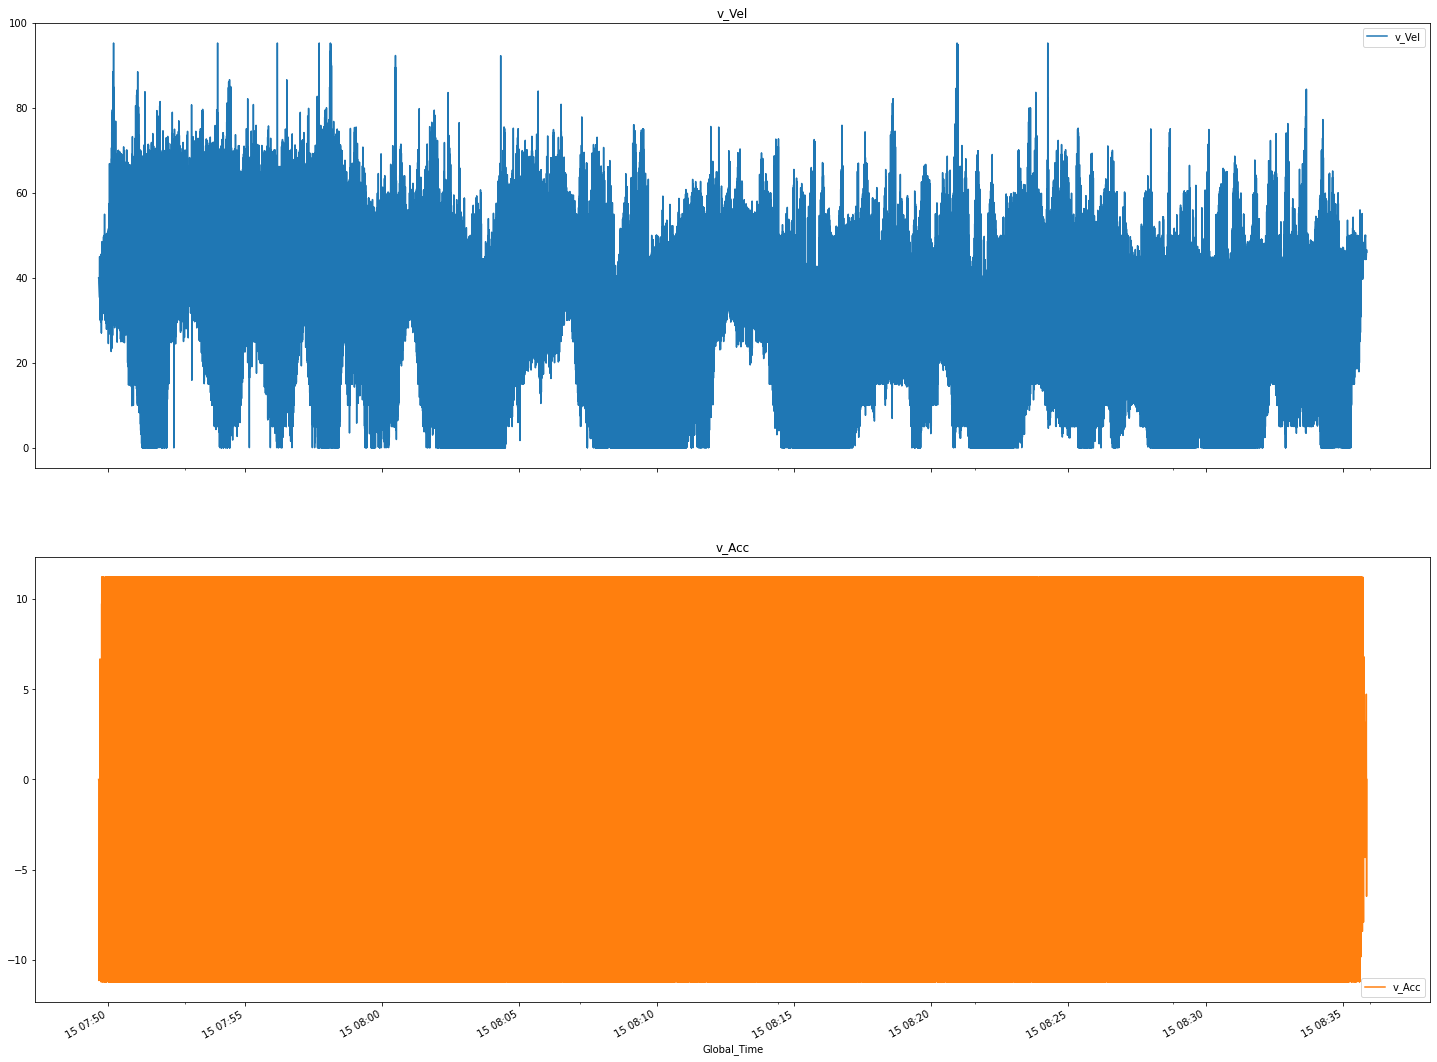

In [21]:
# Time series to show the behaviour of the vehicles velocity and acceleration over time
plt.figure()
ax = df.plot(x='Global_Time', y=speed_columns, kind='line', figsize=(25, 20), subplots=True,
                title=speed_columns)

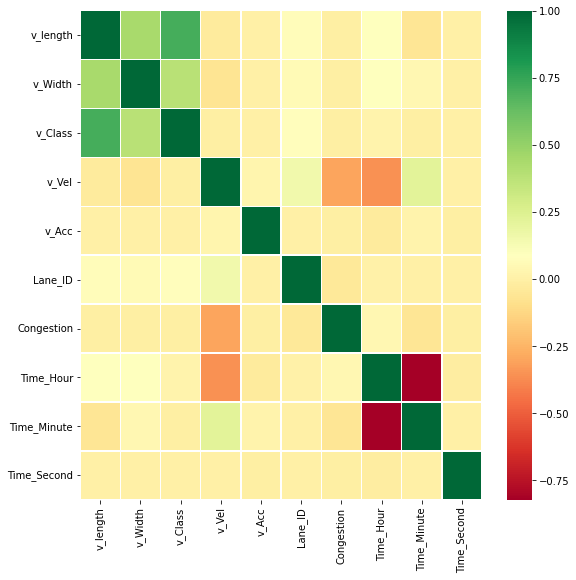

In [22]:
# Heatmap to show the correlation between the variables
corr = df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')

From the heatmap we can tell the following:
- Strong correlation between the hour and minute
- Weak correlation between congestion and the vehicles velocity
- Weak correlations between the hour, minute, lane and the vehicles velocity

Could the hour, minute, lane influence the vehicles velocity and correlation?

In [23]:
df.Time.describe()

count       455846
unique        2772
top       08:31:24
freq           292
Name: Time, dtype: object

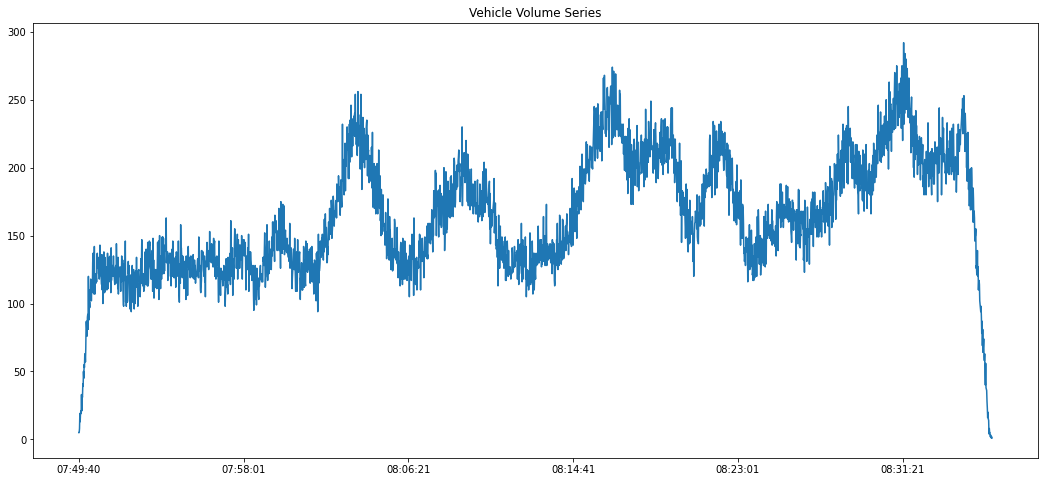

In [24]:
ax = df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

In [25]:
ax.get_figure().savefig('Vehicle Volume.png')

# Model Building

#### Preparing the data

In [26]:
# Dataframe to be used for model prediction
data = df.iloc[:, 1:11]

In [27]:
data.head()

,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Congestion,Time_Hour,Time_Minute,Time_Second
0,13.0,6.9,2.0,23.31,2.05,3.0,0,8,7,55
1,13.5,6.9,2.0,37.52,11.20,2.0,0,8,0,24
2,13.5,4.4,2.0,41.99,0.10,1.0,0,8,12,4
3,24.0,8.5,3.0,45.12,-0.55,5.0,0,8,34,32
4,15.0,5.9,2.0,24.54,-0.04,3.0,0,8,9,41


In [28]:
# Select feature columns and convert them to a numpy array
X = data.drop('Congestion', axis=1).values

In [29]:
X

array([[13. ,  6.9,  2. , ...,  8. ,  7. , 55. ],
       [13.5,  6.9,  2. , ...,  8. ,  0. , 24. ],
       [13.5,  4.4,  2. , ...,  8. , 12. ,  4. ],
       ...,
       [16.5,  6.4,  2. , ...,  8. , 16. , 31. ],
       [13.5,  5.9,  2. , ...,  8. , 15. , 56. ],
       [14.5,  7.4,  2. , ...,  8. , 33. , 22. ]])

In [30]:
# Select label columns and convert them to a numpy array
y = data.Congestion.values

In [31]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
# Split the data into the training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [33]:
# Feature scaling by standardizing the data for prediction
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Building the neural network

In [34]:
# Initializing the neural network
model = Sequential()

##### Adding the layers

In [35]:
# Input layer with 9 nodes and a hidden layer with 5 nodes using the relu activation function
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))

In [36]:
# Output layer with 1 node using the sigmoid activation function
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [37]:
# Compile the neural network
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [38]:
# Uncomment to train the model
model.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
31910/31910 [==============================] - 42s 1ms/step - loss: 0.0271 - accuracy: 0.9926
Epoch 2/100
31910/31910 [==============================] - 42s 1ms/step - loss: 0.0069 - accuracy: 0.9979
Epoch 3/100
31910/31910 [==============================] - 41s 1ms/step - loss: 0.0058 - accuracy: 0.9981
Epoch 4/100
31910/31910 [==============================] - 41s 1ms/step - loss: 0.0053 - accuracy: 0.9983
Epoch 5/100
31910/31910 [==============================] - 42s 1ms/step - loss: 0.0050 - accuracy: 0.9984
Epoch 6/100
31910/31910 [==============================] - 41s 1ms/step - loss: 0.0048 - accuracy: 0.9984
Epoch 7/100
31910/31910 [==============================] - 42s 1ms/step - loss: 0.0046 - accuracy: 0.9985
Epoch 8/100
31910/31910 [==============================] - 41s 1ms/step - loss: 0.0046 - accuracy: 0.9986
Epoch 9/100
31910/31910 [==============================] - 42s 1ms/step - loss: 0.0045 - accuracy: 0.9986
Epoch 10/100
31910/31910 [====================

In [39]:
# Save the model
# model.save('models/neural_congestion_ds.keras')

In [40]:
# model = load_model('models/neural_congestion_ds.keras', compile=False)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 50        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Use the model for predictions and convert probabilities above 0.5 to 1
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

In [43]:
# Check the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[134065     96]
 [    27   2566]]


In [44]:
# Check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    134161
           1       0.96      0.99      0.98      2593

    accuracy                           1.00    136754
   macro avg       0.98      0.99      0.99    136754
weighted avg       1.00      1.00      1.00    136754



In [45]:
# Check auc score
print(roc_auc_score(y_test, y_pred))

0.9944358961932773


### Undersampling and making predictions

In [46]:
undersampler = RandomUnderSampler(sampling_strategy='majority')

In [47]:
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

In [48]:
Counter(y_train)

Counter({0: 313077, 1: 6015})

In [49]:
Counter(y_undersampled)

Counter({0: 6015, 1: 6015})

In [50]:
# Initializing the neural network
model = Sequential()

In [51]:
# Input layer with 9 nodes and a hidden layer with 5 nodes using the relu activation function
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))

In [52]:
# Output layer with 1 node using the sigmoid activation function
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [53]:
# Compile the neural network
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [54]:
# Uncomment to train the model
model.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
31910/31910 [==============================] - 41s 1ms/step - loss: 0.0294 - accuracy: 0.9942
Epoch 2/100
31910/31910 [==============================] - 40s 1ms/step - loss: 0.0078 - accuracy: 0.9974
Epoch 3/100
31910/31910 [==============================] - 40s 1ms/step - loss: 0.0061 - accuracy: 0.9980
Epoch 4/100
31910/31910 [==============================] - 40s 1ms/step - loss: 0.0054 - accuracy: 0.9983
Epoch 5/100
31910/31910 [==============================] - 41s 1ms/step - loss: 0.0049 - accuracy: 0.9985
Epoch 6/100
31910/31910 [==============================] - 40s 1ms/step - loss: 0.0046 - accuracy: 0.9985
Epoch 7/100
31910/31910 [==============================] - 41s 1ms/step - loss: 0.0044 - accuracy: 0.9985
Epoch 8/100
31910/31910 [==============================] - 40s 1ms/step - loss: 0.0043 - accuracy: 0.9987
Epoch 9/100
31910/31910 [==============================] - 40s 1ms/step - loss: 0.0042 - accuracy: 0.9987
Epoch 10/100
31910/31910 [====================

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 5)                 50        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Use the model for predictions and convert probabilities above 0.5 to 1
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

In [57]:
# Check the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[133992    169]
 [     1   2592]]


In [58]:
# Check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    134161
           1       0.94      1.00      0.97      2593

    accuracy                           1.00    136754
   macro avg       0.97      1.00      0.98    136754
weighted avg       1.00      1.00      1.00    136754



In [59]:
f1_score(y_test, y_pred)

0.9682480388494583

In [60]:
accuracy_score(y_test, y_pred)

0.9987568919373474

In [61]:
# Check auc score
print(roc_auc_score(y_test, y_pred))

0.9991773328919582
